In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [28]:
# select model
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
root = '/kaggle/input/digit-recognizer'

# load data

In [3]:
train_data = pd.read_csv(os.path.join(root, 'train.csv'))
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Analyze data

In [4]:
train_data.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [5]:
Y = train_data['label']
images = train_data.drop(['label'], axis=1)
print(images.shape, Y.shape)
del train_data

(42000, 784) (42000,)


In [6]:
X = images.to_numpy(dtype='float32').reshape((42000, 28, 28, 1)) / 255.0
X.shape

(42000, 28, 28, 1)

# Show image

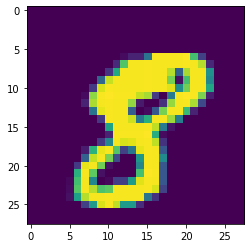

In [7]:
import matplotlib.pyplot as plt
plt.imshow(X[10])

# select model

In [8]:
num_classes = 10

Y = to_categorical(Y, num_classes=num_classes)

In [11]:
def summarize_diagnostics(history):
    plt.subplot(221)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.subplot(222)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    pass

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=(28, 28, 1), activation='relu'))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

2022-05-16 15:22:53.872308: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        3

In [12]:
datagen = ImageDataGenerator(rotation_range=5,
                             zoom_range = 0.01,
                             width_shift_range=0.1, 
                             height_shift_range=0.1
                            )
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [14]:
steps = int(X.shape[0] // 64)
history = model.fit(datagen.flow(X, Y, batch_size=32),
                    steps_per_epoch=steps, epochs=40, batch_size=64, verbose=0)

2022-05-16 15:22:54.360857: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [17]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print(type(train_X), train_X.shape, test_X.shape)

11501568/11490434 [==============================] - 0s 0us/step
<class 'numpy.ndarray'> (60000, 28, 28) (10000, 28, 28)


In [18]:
X = np.concatenate((train_X, test_X), axis=0)
Y = np.concatenate((train_y, test_y), axis=0)
print(X.shape, Y.shape)

(70000, 28, 28) (70000,)


In [19]:
X = X.reshape(-1, 28, 28, 1)
X.shape

(70000, 28, 28, 1)

In [20]:
X = X / 255.0
Y = to_categorical(Y, num_classes=num_classes)
Y.shape

(70000, 10)

In [21]:
history = model.fit(x=X, y=Y, batch_size=64, epochs=100)

Epoch 1/100
1094/1094 [==============================] - 159s 145ms/step - loss: 0.0182 - accuracy: 0.9947
Epoch 2/100
1094/1094 [==============================] - 176s 161ms/step - loss: 0.0144 - accuracy: 0.9958
Epoch 3/100
1094/1094 [==============================] - 163s 149ms/step - loss: 0.0136 - accuracy: 0.9960
Epoch 4/100
1094/1094 [==============================] - 171s 156ms/step - loss: 0.0133 - accuracy: 0.9961
Epoch 5/100
1094/1094 [==============================] - 161s 148ms/step - loss: 0.0117 - accuracy: 0.9964
Epoch 6/100
1094/1094 [==============================] - 169s 154ms/step - loss: 0.0108 - accuracy: 0.9966
Epoch 7/100
1094/1094 [==============================] - 164s 150ms/step - loss: 0.0117 - accuracy: 0.9965
Epoch 8/100
1094/1094 [==============================] - 156s 143ms/step - loss: 0.0098 - accuracy: 0.9970
Epoch 9/100
1094/1094 [==============================] - 160s 146ms/step - loss: 0.0096 - accuracy: 0.9972
Epoch 10/100
1094/1094 [=============

In [22]:
test = pd.read_csv(os.path.join(root, 'test.csv'))
test = test / 255.0
test = np.array(test).reshape(-1,28,28,1)

In [23]:
y_pred = model.predict(test)
y_pred = np.argmax(y_pred, axis=1)

In [24]:
y_pred

array([2, 0, 9, ..., 3, 9, 2])

In [25]:
submission_df = pd.DataFrame()
image_id = [i for i in range(1, 28001)]
submission_df['ImageId'] = image_id
submission_df['Label'] = y_pred
submission_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


# save submission as csv file

In [26]:
submission_df.to_csv('submission.csv', index = False)